# Quantum Imaginary Time Evolution with Bigfridge, single qubit


In this notebook we generate the effective unitary operator for imaginary time-evolution using the QITE algorithm. 
$$ U = e^{iX} $$
$$ X = \sum_m x_mP_m$$
The operator X is a sum of Paulis and can be represented in Qiskit using the Pauli class. From this class we can construct an evolution circuit for Hamiltonians
$$U_t = e^{-iHt}$$
with $t = 1$. Note the difference in sign of the two unitaries. I explicitly change the sign of the operator X before constructing the evolution circuit.

### QITE Numerics, using the measured expectation values

In [1]:
import numpy as np
from hamiltonian      import Heisenberg_LR,Heisenberg_SR,print_Hamiltonian, Hmat, TransverseIsing, single_qubit_field
from mf               import hom_mf_solution,hom_mf_state,hom_mf_energy,mf_solution,mf_state,mf_energy
#from ite              import ITE_FCI
#from qite             import QITE
from binary_functions import Bas2Int
from math import ceil, floor, pi, sqrt
from   scipy            import linalg as SciLA
import scipy
from   numpy            import linalg as LA
import sys
import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
nspin =  1
R     =  0.5
db    =  0.7
bmax  =  3.00
J = 1/np.sqrt(2)
h = J
H = TransverseIsing(nspin, R, J, h)
print('Hamiltonian')
print_Hamiltonian(H)
psi_0       = np.zeros(2**nspin,dtype=complex)
xvec        = [0,1]*ceil((nspin/2))
xind        = Bas2Int(xvec,2)
psi_0[0] = 1.0

[0]

[[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]
Hamiltonian
active qubits  [0]
operators: 
X 0.7071067811865475
Z 0.7071067811865475


### Definitions of the functions, can be put in a separate file

In [3]:
# Defs of the needed functions, for 1 qubit for now

# Pauli matrices
Id= np.array([[1, 0],[0, 1]])
sigma_x = np.array([[0, 1],[1, 0]])
sigma_y = np.array([[0, -1j],[1j, 0]])
sigma_z = np.array([[1, 0],[0, -1]])

# Gives 4 expectation values from a wavefunction as psi_0:
# This one is only useful to run this on my computer, won't be used on the experimental setup
def GiveExpValues(psi):
    return np.array([np.dot(psi,np.dot(Id,psi)),np.dot(psi,np.dot(sigma_x,psi)),np.dot(psi,np.dot(sigma_y,psi)),np.dot(psi,np.dot(sigma_z,psi))])

# Table gives Pauli matrix from product of pauli matrices sigma_i*sigma_j. Two indices go from 0 to 3
TablePauliMatrices=np.array([[0, 1, 2, 3],
                               [1, 0, 3, 2],
                               [2, 3, 0, 1],
                               [3, 2, 1, 0]])
TableCoeffPauliMatrices=np.array([[1, 1, 1, 1],
                                   [1, 1, 1j, -1j],
                                   [1, -1j, 1, 1j],
                                   [1, 1j, -1j, 1]])

# Compute Norm of the vector evolved after one step, from the Expectation Values of the pauli
def ComputeNormFromExpectValues(ExpectationValues, db, h):
    Normsq=0
    Pm_coeffs=np.array([1-db*h[0], -db*h[1],-db*h[2],-db*h[3]])
    for i1 in range(4):
        for i2 in range(4):
            Normsq+=np.conj(Pm_coeffs[i1])*Pm_coeffs[i2]*TableCoeffPauliMatrices[i1,i2]*ExpectationValues[TablePauliMatrices[i1,i2]]
    return np.sqrt(Normsq)

# Compute the A matrix
def ComputeAmat(ExpectationValues):
    AmatUs=np.zeros((4,4))
    for i1 in range(4):
        for i2 in range(4):
            AmatUs[i1,i2]=2*np.real(TableCoeffPauliMatrices[i1,i2]*ExpectationValues[TablePauliMatrices[i1,i2]])
    return AmatUs

# Compute the b vector
def Computebvec(ExpectationValues,db,h,Norm):
    bvecUs=np.zeros(4)
    Pm_coeffs=np.array([1-db*h[0], -db*h[1],-db*h[2],-db*h[3]])
    for i1 in range(4):
        for i2 in range(4):
            bvecUs[i1]+=2*np.imag(np.conj(Pm_coeffs[i2])/Norm*TableCoeffPauliMatrices[i2,i1]*ExpectationValues[TablePauliMatrices[i2,i1]])
    bvecUs=-bvecUs # I don't now why the minus, but matches result of qite.py
    return bvecUs

# Now solve Ax=b, following their code in qite.py
def Getxvector(AmatUs,bvecUs):
    zct  = np.dot(bvecUs,AmatUs)
    def cost_fun(vct):
        return LA.norm(np.dot(AmatUs,vct)-bvecUs)**2
    def J_cost_fun(vct):
        wct = np.dot(AmatUs,vct)
        wct = np.dot(AmatUs.T,wct)
        return 2.0*(wct-zct)
    x0=np.zeros(4)
    x    = scipy.optimize.minimize(cost_fun,x0,method='Newton-CG',jac=J_cost_fun,tol=1e-8).x
    return x

def ComputeEnergy(ExpectationValues,h):
    Energy=0
    for i1 in range(4):
        Energy+=h[i1]*ExpectationValues[i1]
    return Energy

# This function will have to be translated for the experimental setup
def Rotation_y(theta):
    return np.cos(theta)*Id+1j*np.sin(theta)*sigma_y

In [4]:
# We define here our qite algo

# I need to get h: 
(A,h,imp,gmp) = H[0]

# Def psi_0
psi_0       = np.zeros(2**nspin,dtype=complex)
psi_0[0] = 1.0

nbeta = int(bmax/db)+1
xarray=np.zeros((nbeta,4))
Energies=[]
psi=psi_0
for ib in range(nbeta):
    
    ExpectationValues=GiveExpValues(psi) # We get this from qpu instead
    
    Norm=ComputeNormFromExpectValues(ExpectationValues, db, h)
    AmatUs=ComputeAmat(ExpectationValues)
    bvecUs=Computebvec(ExpectationValues,db,h,Norm)
    x=Getxvector(AmatUs,bvecUs)
    #xlist.append(x)
    xarray[ib]=x
    Energy=ComputeEnergy(ExpectationValues,h)
    Energies.append(Energy)
    #print(Energy)
    psi=np.dot(Rotation_y(np.sum(xarray[:,2])),psi_0) # We extract sequence from here, simple for now. With pi/2, Rz(angle), pi/2
    #print(psi)

In [5]:
# We define here our qite algo, just compare if we use another chi'...

# I need to get h: 
(A,h,imp,gmp) = H[0]

# Def psi_0
psi_0       = np.zeros(2**nspin,dtype=complex)
psi_0[0] = 1.0

xlist=[]
Energies2=[]

nbeta = int(bmax/db)+1
psi=psi_0
for ib in range(nbeta):
    ExpectationValues=GiveExpValues(psi)
    Norm=ComputeNormFromExpectValues(ExpectationValues, db, h)
    AmatUs=ComputeAmat(ExpectationValues)
    bvecUs=Computebvec(ExpectationValues,db,h,Norm)
    x=Getxvector(AmatUs,bvecUs)
    xlist.append(x)
    Energy=ComputeEnergy(ExpectationValues,h)
    Energies2.append(Energy)
    #print(Energy)
    #psi=np.dot(Rotation_y(x[2]),psi)
    #or 
    Pm_coeffs=np.array([1-db*h[0], -db*h[1],-db*h[2],-db*h[3]])
    psi=np.dot(Pm_coeffs[0]*Id+Pm_coeffs[1]*sigma_x+Pm_coeffs[2]*sigma_y+Pm_coeffs[3]*sigma_z,psi)/Norm

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))

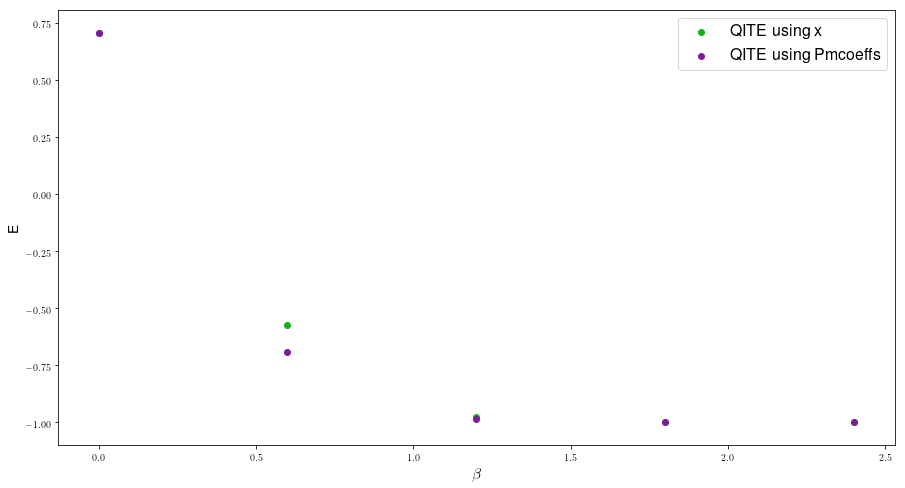

In [6]:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fig = plt.figure(figsize=(15,8))
plt1 = fig.add_subplot(111)

plt1.scatter(np.linspace(0,bmax,nbeta,endpoint=False),Energies, color='xkcd:green', label='QITE using x')
plt1.scatter(np.linspace(0,bmax,nbeta,endpoint=False),Energies2, color='xkcd:purple', label='QITE using Pmcoeffs')

plt1.set_ylabel('E', fontsize=14)
plt1.set_xlabel(r'$\beta$',fontsize=16)
plt.legend(loc='upper right', fontsize=16)
plt.show()